In [1]:
import os
import os.path
import csv
import time
import PIL
import math
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from ImageNet import *
from CNN import *
from ResNet import *
from utils import *


In [2]:
# Initialize dataset related parameters
data_dir = './data'

workers = 1
batch_size = 64

######################## task 3.1 ##########################

max_epochs = 50
lr = 0.001

########################    END   ##########################


gpu = torch.cuda.is_available()

if gpu:
    print('Training on GPU')
else:
    print('Training on CPU')

Training on GPU


In [3]:
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.480, 0.448, 0.398], [0.272, 0.265, 0.274])
])

transform1 = transforms.RandomApply([
    ######################## task 0.1 ##########################
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(p=0.5)
    
])
########################    END   ##########################

# transform2 = transforms.ToTensor()

In [4]:
dataset = TinyImageNetDataset(data_dir+'/train', transform=transforms.Compose([transform1, transform2]))
datasetForVal = TinyImageNetDataset(data_dir+'/train', transform=transforms.Compose([transform2]))
labels = dataset.get_labels()

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
idx_tr, idx_val = next(sss.split(labels, labels))
print(idx_tr, idx_val)

dataset_tr = torch.utils.data.Subset(dataset, idx_tr)
dataset_val = torch.utils.data.Subset(datasetForVal, idx_val)

dataloader_tr = torch.utils.data.DataLoader(dataset_tr, batch_size=batch_size, shuffle=True, num_workers=workers)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=workers)

print('Training Dataset Length: ' + str(len(dataset_tr)))
print('Validation Dataset Length: ' + str(len(dataset_val)))

class_to_idx = dataset.get_class_to_idx()
dataset_test = TinyImageNetTestDataset(data_dir+'/val', annot_filename = 'val_annotations.txt', class_to_idx = class_to_idx,transform=transform2)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=workers)

print('Test Dataset Length: ' + str(len(dataset_test)))

[91085 94451 25171 ... 91719 14797 81517] [31020 44828 57231 ... 91983 79905 70024]
Training Dataset Length: 90000
Validation Dataset Length: 10000
Test Dataset Length: 10000


In [5]:
model = CNN()
model.apply(init_weights)
if gpu:
    model.cuda()

######################## task 3.2 ##########################
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()
########################    END   ##########################

model_filename = 'mymodel.pth'

In [6]:
def train(dataloader, model, optimizer, criterion):
    batch = 0
    loss = 0.0
    correct = 0.0

    model.train()    
    
    with tqdm(total=len(dataloader.dataset), desc='train', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
        for X, Y in dataloader:
            if gpu:
                X = X.cuda()
                Y = Y.cuda()
            optimizer.zero_grad()        
            logits = model(X)
            cur_loss = criterion(logits, Y)
            cur_loss.backward()
            optimizer.step()
            loss += cur_loss.item()
            pred = logits.argmax(dim = 1)
            correct += pred.eq(Y).sum()
            
            pbar.update(dataloader.batch_size)

    
    loss = loss / float(len(dataloader.dataset))
    accuracy = float(correct) / float(len(dataloader.dataset)) * 100
    
    return loss, accuracy

In [7]:
def validate(dataloader, model, criterion):
    
    ######################## task 3.3 ##########################
    batch = 0
    loss = 0.0
    correct = 0.0

    model.eval()
    
    with torch.no_grad():
    
        with tqdm(total=len(dataloader.dataset), desc='val', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
            for X, Y in dataloader:
                if gpu:
                    X = X.cuda()
                    Y = Y.cuda()      
                logits = model(X)
                cur_loss = criterion(logits, Y)
                loss += cur_loss.item()
                pred = logits.argmax(dim = 1)
                correct += pred.eq(Y).sum()

                pbar.update(dataloader.batch_size)

    
    loss = loss / float(len(dataloader.dataset))
    accuracy = float(correct) / float(len(dataloader.dataset)) * 100
    

    ########################    END   ##########################
    
    return loss, accuracy

In [8]:
def test(model, dataloader):
    
    ######################## task 3.4 ##########################
    batch = 0
    loss = 0.0
    correct = 0.0

    model.eval()
    
    with torch.no_grad():
    
        with tqdm(total=len(dataloader.dataset), desc='val', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
            for X, Y in dataloader:
                if gpu:
                    X = X.cuda()
                    Y = Y.cuda()      
                logits = model(X)
                cur_loss = criterion(logits, Y)
                loss += cur_loss.item()
                pred = logits.argmax(dim = 1)
                correct += pred.eq(Y).sum()

                pbar.update(dataloader.batch_size)

    
    loss = loss / float(len(dataloader.dataset))
    accuracy = float(correct) / float(len(dataloader.dataset)) * 100
    

    ########################    END   ##########################
    
    return pred, loss, accuracy


In [9]:
def fit(dataloader_tr, dataloader_val, model, criterion, optimizer, max_epoch = 100, scheduler = None, filename = None, early_stop = True, patience = 10, resume = False):
    start_epoch = 0
    early_stop_counter = 0
    min_loss_val = 1e10    
    loss_tr_hist = []
    loss_val_hist = []
    accuracy_tr_hist = []
    accuracy_val_hist = []

    if resume == True:
        if filename is None:
            print('Please Provide File Name to load model')
            return
        start_epoch, model, optimizer, scheduler, early_stop_counter, loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist = load_model(filename, model, optimizer, scheduler, mode = 'train')
        
        
    for epoch in range(start_epoch+1, max_epoch + 1):
        print('epoch:' ,epoch)
        t0 = time.time()

        loss_tr, accuracy_tr = train(dataloader_tr, model, optimizer, criterion)
        loss_tr_hist.append(loss_tr)
        accuracy_tr_hist.append(accuracy_tr)

        loss_val, accuracy_val = validate(dataloader_val, model, criterion)
        loss_val_hist.append(loss_val)
        accuracy_val_hist.append(accuracy_val)
        
        print('tr_acc:',accuracy_tr,'val_acc:',accuracy_val,'tr_loss:',loss_tr,'val_loss:',loss_val)
        
        if scheduler is not None:
            scheduler.step(loss_val)

        ######################## task 3.5 ##########################
        if loss_val<min_loss_val:
            save_model(filename, model, optimizer, scheduler, epoch, loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist, early_stop_counter)
            early_stop_counter = 0
            min_loss_val = loss_val
        else:
            early_stop_counter += 1
            if early_stop_counter>patience:
                print(f"early stop in epoch:{epoch}")
                break
        ########################    END   ##########################
        
    return loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist

In [10]:
loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist = fit(
    
            ######################## task 3.6 ##########################
    dataloader_tr, 
    dataloader_val,
    model,
    criterion,
    optimizer,
    max_epochs,
    scheduler,
    filename = model_filename,
#     early_stop = False,
    patience = 3
    
            ########################    END   ##########################
            )

epoch: 1


train: 90.0kB [00:52, 1.73kB/s]                                                                     
val: 10.0kB [00:06, 1.59kB/s]                                                                       


tr_acc: 9.48 val_acc: 14.940000000000001 tr_loss: 0.06807518944210476 val_loss: 0.06112691266536713
epoch: 2


train: 90.0kB [00:48, 1.84kB/s]                                                                     
val: 10.0kB [00:06, 1.61kB/s]                                                                       


tr_acc: 19.295555555555556 val_acc: 19.02 tr_loss: 0.05654288742012448 val_loss: 0.05760667803287506
epoch: 3


train: 90.0kB [00:49, 1.82kB/s]                                                                     
val: 10.0kB [00:06, 1.59kB/s]                                                                       


tr_acc: 24.136666666666667 val_acc: 24.709999999999997 tr_loss: 0.05182343943383959 val_loss: 0.052215188932418825
epoch: 4


train: 90.0kB [00:49, 1.83kB/s]                                                                     
val: 10.0kB [00:06, 1.60kB/s]                                                                       


tr_acc: 28.12 val_acc: 26.63 tr_loss: 0.04846989277203878 val_loss: 0.05072258622646332
epoch: 5


train: 90.0kB [00:49, 1.82kB/s]                                                                     
val: 10.0kB [00:06, 1.59kB/s]                                                                       


tr_acc: 31.09444444444445 val_acc: 25.56 tr_loss: 0.04587271112336053 val_loss: 0.05252774021625519
epoch: 6


train: 90.0kB [00:49, 1.82kB/s]                                                                     
val: 10.0kB [00:06, 1.59kB/s]                                                                       


tr_acc: 33.84666666666667 val_acc: 29.32 tr_loss: 0.04374655004209942 val_loss: 0.048707715082168576
epoch: 7


train: 90.0kB [00:49, 1.81kB/s]                                                                     
val: 10.0kB [00:06, 1.62kB/s]                                                                       


tr_acc: 36.062222222222225 val_acc: 31.34 tr_loss: 0.041945845577451915 val_loss: 0.04679759740829468
epoch: 8


train: 90.0kB [00:49, 1.83kB/s]                                                                     
val: 10.0kB [00:06, 1.60kB/s]                                                                       


tr_acc: 38.114444444444445 val_acc: 31.6 tr_loss: 0.04028751565880245 val_loss: 0.04731757302284241
epoch: 9


train: 90.0kB [00:49, 1.82kB/s]                                                                     
val: 10.0kB [00:06, 1.55kB/s]                                                                       


tr_acc: 39.75111111111111 val_acc: 32.74 tr_loss: 0.03878901677661472 val_loss: 0.04571572456359863
epoch: 10


train: 90.0kB [00:49, 1.81kB/s]                                                                     
val: 10.0kB [00:06, 1.60kB/s]                                                                       


tr_acc: 41.71666666666667 val_acc: 32.83 tr_loss: 0.037357474209202664 val_loss: 0.04641964147090912
epoch: 11


train: 90.0kB [00:49, 1.84kB/s]                                                                     
val: 10.0kB [00:06, 1.60kB/s]                                                                       


tr_acc: 43.39 val_acc: 33.78 tr_loss: 0.035991838227378 val_loss: 0.04557709579467773
epoch: 12


train: 90.0kB [00:49, 1.82kB/s]                                                                     
val: 10.0kB [00:06, 1.58kB/s]                                                                       


tr_acc: 44.92777777777778 val_acc: 32.97 tr_loss: 0.034677357987562815 val_loss: 0.04683381953239441
epoch: 13


train: 90.0kB [00:49, 1.82kB/s]                                                                     
val: 10.0kB [00:06, 1.58kB/s]                                                                       


tr_acc: 46.80666666666667 val_acc: 33.25 tr_loss: 0.033316219788127474 val_loss: 0.04684669859409332
epoch: 14


train: 90.0kB [00:49, 1.81kB/s]                                                                     
val: 10.0kB [00:06, 1.61kB/s]                                                                       


tr_acc: 48.449999999999996 val_acc: 33.72 tr_loss: 0.03204247320757972 val_loss: 0.046425367522239684
epoch: 15


train: 90.0kB [00:49, 1.83kB/s]                                                                     
val: 10.0kB [00:06, 1.60kB/s]                                                                       

tr_acc: 50.14222222222222 val_acc: 33.589999999999996 tr_loss: 0.030820563503106434 val_loss: 0.04678108360767364
early stop in epoch:15


In [11]:
model = CNN()
model = load_model(model_filename, model, mode = 'test')
if gpu:
    model.cuda()
pred, loss_test, accuracy_test = test(model, dataloader_test)
print('Test Loss: {0:7.4f}  |  Test Accuracy: {1:7.4f}'.format(loss_test, accuracy_test))

val: 10.0kB [00:07, 1.32kB/s]                                                                       

Test Loss:  0.0461  |  Test Accuracy: 33.4100


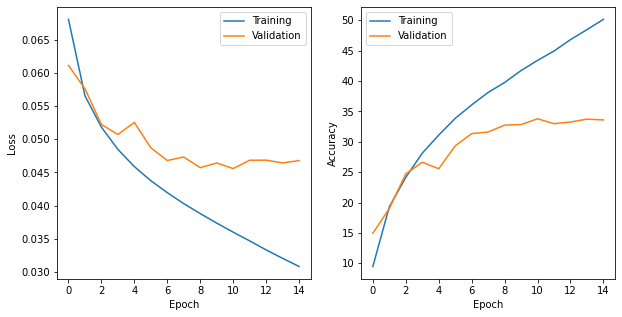

In [12]:
# plot training loss
plot(loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist)